## Imports

In [1]:
# standard imports
import matplotlib.pyplot as plt
import random
import pandas as pd
import glob
import os
import numpy as np
from functools import reduce

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import pyspark.sql.window as window
from pyspark.sql.functions import col, split, when, lit
from pyspark.sql.functions import regexp_extract, input_file_name

## Data Collection

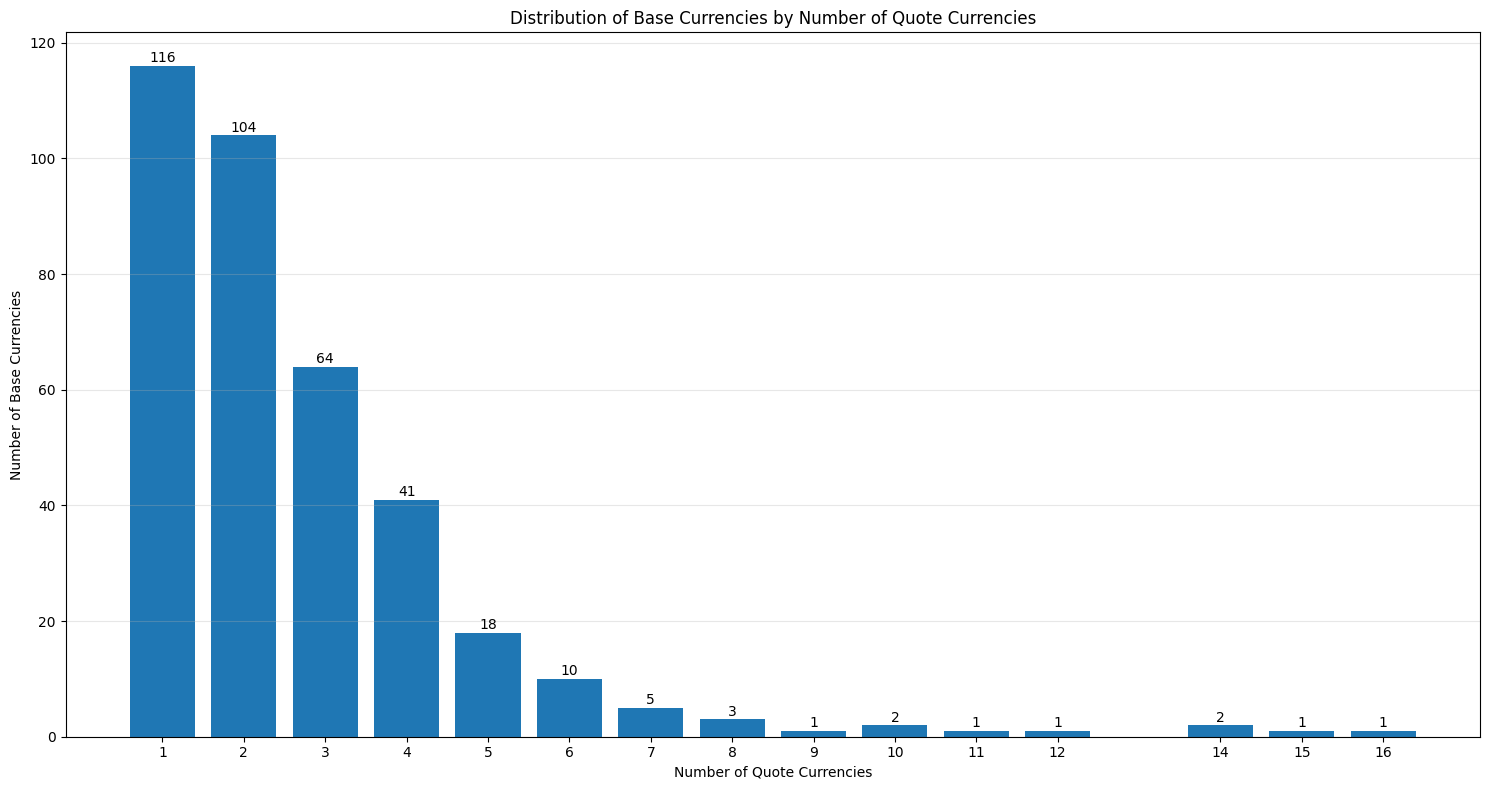

In [2]:
# Directory containing the parquet files
directory = '/mnt/data/public/binance-full-history'
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

base_quote_counts = {}

for file in files:
    # Get base and quote per file name
    base_currency = file.split('-')[0]
    quote_currency = file.split('-')[1].replace('.parquet', '')
    
    if base_currency not in base_quote_counts:
        base_quote_counts[base_currency] = set()
    
    base_quote_counts[base_currency].add(quote_currency)

# Convert to counts
base_counts = {base: len(quotes) for base, quotes in base_quote_counts.items()}

# Create dataframe for plotting
counts_df = pd.DataFrame({
    'base_currency': list(base_counts.keys()),
    'quote_count': list(base_counts.values())
})
quote_count_distribution = counts_df['quote_count'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(15, 8))
bars = plt.bar(
    quote_count_distribution.index, quote_count_distribution.values
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Number of Quote Currencies')
plt.ylabel('Number of Base Currencies')
plt.title('Distribution of Base Currencies by Number of Quote Currencies')
plt.grid(axis='y', alpha=0.3)
plt.xticks(quote_count_distribution.index)

# Saving the figure
plt.tight_layout()
plt.savefig(
    'Figures/Distribution of Base Currencies by Number of Quote Currencies.png'
)
plt.show()

# Get top base currencies
top_bases = counts_df.nlargest(10, 'quote_count')
common_quotes = set.intersection(*(base_quote_counts[base] for base in top_bases['base_currency']))

In [3]:
# Getting the total size of the top base currencies
total_size_bytes = 0
total_size_gb = 0

for _, row in top_bases.iterrows():
    base_currency = row['base_currency']
    quote_count = row['quote_count']
    
    # Find all files for this base currency
    base_files = [f for f in files if f.startswith(f"{base_currency}-")]
    
    # Calculate total size for this base currency
    base_total_size = 0
    for file in base_files:
        file_path = os.path.join(directory, file)
        base_total_size += os.path.getsize(file_path)
    
    # Convert to human readable format
    base_size_mb = base_total_size / (1024 * 1024)
    base_size_gb = base_total_size / (1024 * 1024 * 1024)
    
    # Add to total
    total_size_bytes += base_total_size
    total_size_gb += base_size_gb
    
# Calculate overall totals
total_size_mb = total_size_bytes / (1024 * 1024)
total_all_files_bytes = sum(os.path.getsize(os.path.join(directory, f)) for f in files)
total_all_files_gb = total_all_files_bytes / (1024 * 1024 * 1024)

print(f"{'TOTAL (Top 10)':<24} {total_size_gb:>8.2f} GB ({total_size_mb:>.1f} MB)")
print(f"{'Percentage of All Data':<24} {(total_size_gb/total_all_files_gb)*100:>8.1f}%")
print(f"{'TOTAL (All Files)':<24} {total_all_files_gb:>8.2f} GB")

TOTAL (Top 10)               5.05 GB (5172.9 MB)
Percentage of All Data       15.7%
TOTAL (All Files)           32.22 GB


In [4]:
# Getting the total size of files
total_size_bytes = 0

for base_currency in top_bases['base_currency']:
    for quote_currency in common_quotes:
        file_name = f"{base_currency}-{quote_currency}.parquet"
        if file_name in files:
            file_path = os.path.join(directory, file_name)
            total_size_bytes += os.path.getsize(file_path)

# Convert totals
total_size_mb = total_size_bytes / (1024 * 1024)
total_size_gb = total_size_bytes / (1024 * 1024 * 1024)

# Calculate all-file totals
total_all_files_bytes = sum(os.path.getsize(os.path.join(directory, f)) for f in files)
total_all_files_gb = total_all_files_bytes / (1024 * 1024 * 1024)

# Output
print(f"{'TOTAL (Top Bases + Common Quotes)':<35} {total_size_gb:>8.2f} GB ({total_size_mb:>.1f} MB)")
print(f"{'Percentage of All Data':<35} {(total_size_gb/total_all_files_gb)*100:>8.1f}%")
print(f"{'TOTAL (All Files)':<35} {total_all_files_gb:>8.2f} GB")

TOTAL (Top Bases + Common Quotes)       1.55 GB (1586.4 MB)
Percentage of All Data                   4.8%
TOTAL (All Files)                      32.22 GB


In [5]:
# Initialize Spark Session
spark = SparkSession.builder.appName("TopBasesAnalysis").getOrCreate()
directory = '/mnt/data/public/binance-full-history'

# Getting only target files
file_data = []
for base in top_bases['base_currency']:
    for quote in common_quotes:
        file_name = f"{base}-{quote}.parquet"
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            file_data.append((file_path, base, quote))

# Define classification mapping
classification_map = {
    'stablecoin': ['BUSD', 'USDT'],
    'fiat': ['EUR']
}

# Create DataFrames for each file and add columns
dfs = []
for file_path, base, quote in file_data:
    df = spark.read.parquet(file_path)
    df = df.withColumn("base_currency", lit(base)) \
           .withColumn("quote_currency", lit(quote)) \
           .withColumn("classification", 
                      when(lit(quote).isin(classification_map['stablecoin']), lit('stablecoin'))
                      .when(lit(quote).isin(classification_map['fiat']), lit('fiat'))
                      .otherwise(lit('cryptocurrency')))
    dfs.append(df)

# Union all DataFrames
spark_df = reduce(lambda df1, df2: df1.union(df2), dfs)

print(f"Loaded {len(file_data)} parquet files.")

Loaded 30 parquet files.


In [8]:
spark_df.show()

+-------+-------+-------+-------+------+------------------+----------------+---------------------------+----------------------------+-------------------+-------------+--------------+--------------+
|   open|   high|    low|  close|volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|base_currency|quote_currency|classification|
+-------+-------+-------+-------+------+------------------+----------------+---------------------------+----------------------------+-------------------+-------------+--------------+--------------+
|21.2021|21.2021|21.1948|21.1948| 10.12|         214.51802|               2|                        0.0|                         0.0|2019-09-19 10:01:00|          BNB|          BUSD|    stablecoin|
|21.1948|21.1948|21.1948|21.1948|   0.0|               0.0|               0|                        0.0|                         0.0|2019-09-19 10:02:00|          BNB|          BUSD|    stablecoin|
|21.1948|2

In [6]:
# # Save the filtered data just in case
# df.write.parquet(
#     "Files/top_bases_closing_prices.parquet"
# )

## EDA